# Aprendizaje no supervisado

En este notebook se pretende generar un modelo de aprendizaje no supervisado en el cual se agruparán las películas del dataset de imdb.

In [20]:
!ls ./data

IMDb movies.csv        movies_new_columns.csv titles.tsv
movies_clean.csv       ratings.tsv


In [126]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler
from joblib import dump, load

%matplotlib inline

In [65]:
# Importamos el dataset de películas que hemos creado en el notebook de exploración de los datos
df = pd.read_csv('./data/movies_new_columns.csv')

In [66]:
df.head()

,title,year,duration,country,description,avg_vote,votes,time,length,known,genre_1,genre_2,genre_3
0,L'Inferno,1911,68,Italy,Loosely adapted from Dante's Divine Comedy and...,7.0,2237,Classic,Short,Unknown,Adventure,Drama,Fantasy
1,Fantômas - À l'ombre de la guillotine,1913,54,France,Inspector Juve is tasked to investigate and ca...,7.0,1944,Classic,Short,Unknown,Crime,Drama,Crime
2,Juve contre Fantômas,1913,61,France,In Part Two of Louis Feuillade's 5 1/2-hour ep...,7.0,1349,Classic,Short,Unknown,Crime,Drama,Crime
3,Le mort qui tue,1913,90,France,After a body disappears from inside the prison...,7.0,1050,Classic,Short,Unknown,Crime,Drama,Mystery
4,Lo studente di Praga,1913,85,Germany,"Balduin, a student of Prague, leaves his royst...",6.5,1768,Classic,Short,Unknown,Drama,Fantasy,Horror


Si insertamos actualemten este dataset en un algoritmo de machine learning, para el algoritmo el valor Drama de la columna genre_1 es diferente al valor Drama de la columna genre_2, por lo tanto tenemos que crear una especie de OneHotEncoding manual en el cual se creará una nueva columna por cada género, es decir, genre_drama con valor 1 si esa película es de género drama y 0 en caso contrario.

In [67]:
genre = np.concatenate((df.genre_1.values, df.genre_2.values))

In [68]:
genre = np.concatenate((genre, df.genre_3.values))

In [69]:
np.unique(genre)

array(['Action', 'Adult', 'Adventure', 'Animation', 'Biography', 'Comedy',
       'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy', 'Film-Noir',
       'History', 'Horror', 'Music', 'Musical', 'Mystery', 'Romance',
       'Sci-Fi', 'Sport', 'Thriller', 'War', 'Western'], dtype=object)

Ya podemos sacar los valores únicos del género, por lo que procedemos a crear nuestro OneHotEncoder de géneros

In [70]:
for g in np.unique(genre):
    base = 'genre_' + g.lower()
    df[base] = 0
    
    for index, row in df.iterrows():
        df.loc[index, base] = 1 if df.loc[index, 'genre_1'] == g else df.loc[index, base]
        df.loc[index, base] = 1 if df.loc[index, 'genre_2'] == g else df.loc[index, base]
        df.loc[index, base] = 1 if df.loc[index, 'genre_3'] == g else df.loc[index, base]
        

In [71]:
df.columns

Index(['title', 'year', 'duration', 'country', 'description', 'avg_vote',
       'votes', 'time', 'length', 'known', 'genre_1', 'genre_2', 'genre_3',
       'genre_action', 'genre_adult', 'genre_adventure', 'genre_animation',
       'genre_biography', 'genre_comedy', 'genre_crime', 'genre_documentary',
       'genre_drama', 'genre_family', 'genre_fantasy', 'genre_film-noir',
       'genre_history', 'genre_horror', 'genre_music', 'genre_musical',
       'genre_mystery', 'genre_romance', 'genre_sci-fi', 'genre_sport',
       'genre_thriller', 'genre_war', 'genre_western'],
      dtype='object')

In [72]:
df[['genre_fantasy', 'genre_drama', 'genre_3', 'genre_2', 'genre_1']].head(2)

,genre_fantasy,genre_drama,genre_3,genre_2,genre_1
0,1,1,Fantasy,Drama,Adventure
1,0,1,Crime,Drama,Crime


In [73]:
# Una vez tenemos nuestro OnehotEncoding personalizado, borramos las columnas genre_1, genre_2 y genre_3
df = df.drop(['genre_1', 'genre_2', 'genre_3'], axis=1)

In [74]:
df.columns

Index(['title', 'year', 'duration', 'country', 'description', 'avg_vote',
       'votes', 'time', 'length', 'known', 'genre_action', 'genre_adult',
       'genre_adventure', 'genre_animation', 'genre_biography', 'genre_comedy',
       'genre_crime', 'genre_documentary', 'genre_drama', 'genre_family',
       'genre_fantasy', 'genre_film-noir', 'genre_history', 'genre_horror',
       'genre_music', 'genre_musical', 'genre_mystery', 'genre_romance',
       'genre_sci-fi', 'genre_sport', 'genre_thriller', 'genre_war',
       'genre_western'],
      dtype='object')

Para el algoritmo de kmeans no usaremos title, description, duration, year, country, avg_vote, votes

In [75]:
df_transformed = df.drop(['title', 'description', 'duration', 'year', 'country', 'avg_vote', 'votes'], axis=1)

In [76]:
df_transformed.head()

,time,length,known,genre_action,genre_adult,genre_adventure,genre_animation,genre_biography,genre_comedy,genre_crime,...,genre_horror,genre_music,genre_musical,genre_mystery,genre_romance,genre_sci-fi,genre_sport,genre_thriller,genre_war,genre_western
0,Classic,Short,Unknown,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Classic,Short,Unknown,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,Classic,Short,Unknown,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,Classic,Short,Unknown,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
4,Classic,Short,Unknown,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [77]:
# Utilizamos OnehotEncoding con get_dummies de pandas
df_transformed = pd.get_dummies(df_transformed)

In [78]:
df_transformed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29374 entries, 0 to 29373
Data columns (total 32 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   genre_action       29374 non-null  int64
 1   genre_adult        29374 non-null  int64
 2   genre_adventure    29374 non-null  int64
 3   genre_animation    29374 non-null  int64
 4   genre_biography    29374 non-null  int64
 5   genre_comedy       29374 non-null  int64
 6   genre_crime        29374 non-null  int64
 7   genre_documentary  29374 non-null  int64
 8   genre_drama        29374 non-null  int64
 9   genre_family       29374 non-null  int64
 10  genre_fantasy      29374 non-null  int64
 11  genre_film-noir    29374 non-null  int64
 12  genre_history      29374 non-null  int64
 13  genre_horror       29374 non-null  int64
 14  genre_music        29374 non-null  int64
 15  genre_musical      29374 non-null  int64
 16  genre_mystery      29374 non-null  int64
 17  genre_romanc

In [79]:
# Una vez que tenemos todos los datos de tipo numérico, vamos a normalizarlos, es decir, darles valor entre 0 y 1
mms = MinMaxScaler()
df_transformed = mms.fit_transform(df_transformed)

In [80]:
df_transformed.max(), df_transformed.min()

(1.0, 0.0)

Ya tenemos los datos limpios y normalizados, ahora vamos a comprobar cuál sería el número de clusters (k) ideal para nuestro modelo. Esto lo hacemos con la función [silhouette_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html?highlight=silhouette_score#sklearn.metrics.silhouette_score) de sklearn.

In [114]:
# Uso de silhouette para obtener el mejor número de clusters en función de nuestros datos
score_silhouette = list()

K = np.arange(400, 500, 20)
for k in K:
    km = KMeans(n_clusters=k, n_init=30, random_state=2, init='k-means++', max_iter=500)
    km = km.fit(df_transformed)
    score_silhouette.append(silhouette_score(df_transformed, km.labels_))

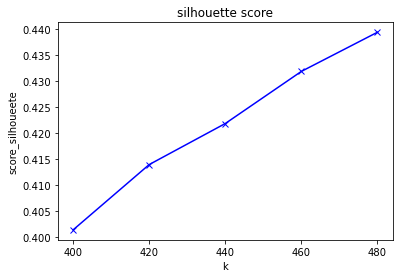

In [115]:
plt.plot(K, score_silhouette, 'bx-')
plt.xlabel('k')
plt.ylabel('score_silhoueete')
plt.xticks(K)
plt.title('silhouette score')
plt.show()

Una vez que hemos comprobado el número de cluster que mejor se comporta con nuestros datos, vamos a crear un modelo kmeans con k = 500

In [116]:
# Obtenemos nuestro modelo con kmeans
k=500
kmeans = KMeans(n_clusters=k, random_state=2, n_init=100, init='k-means++', max_iter=1000).fit(df_transformed)
labels = kmeans.labels_

In [117]:
labels

array([381, 107, 107, ..., 143, 279, 102], dtype=int32)

In [118]:
len(labels)

29374

In [119]:
df['labels'] = labels

In [120]:
df.head()

,title,year,duration,country,description,avg_vote,votes,time,length,known,...,genre_music,genre_musical,genre_mystery,genre_romance,genre_sci-fi,genre_sport,genre_thriller,genre_war,genre_western,labels
0,L'Inferno,1911,68,Italy,Loosely adapted from Dante's Divine Comedy and...,7.0,2237,Classic,Short,Unknown,...,0,0,0,0,0,0,0,0,0,381
1,Fantômas - À l'ombre de la guillotine,1913,54,France,Inspector Juve is tasked to investigate and ca...,7.0,1944,Classic,Short,Unknown,...,0,0,0,0,0,0,0,0,0,107
2,Juve contre Fantômas,1913,61,France,In Part Two of Louis Feuillade's 5 1/2-hour ep...,7.0,1349,Classic,Short,Unknown,...,0,0,0,0,0,0,0,0,0,107
3,Le mort qui tue,1913,90,France,After a body disappears from inside the prison...,7.0,1050,Classic,Short,Unknown,...,0,0,1,0,0,0,0,0,0,107
4,Lo studente di Praga,1913,85,Germany,"Balduin, a student of Prague, leaves his royst...",6.5,1768,Classic,Short,Unknown,...,0,0,0,0,0,0,0,0,0,20


In [121]:
test = df_transformed[0].reshape(1, -1)
test.shape

(1, 32)

In [122]:
kmeans.predict(test)

array([381], dtype=int32)

In [123]:
df.loc[0, 'labels']

381

In [124]:
df.labels.value_counts()

4      635
51     456
61     426
48     351
79     330
      ... 
440      7
256      7
346      6
87       5
485      3
Name: labels, Length: 500, dtype: int64

In [125]:
df.to_csv('./data/movies_labels.csv', index=False, header=True)

#### Almacenamos el modelo

Una vez que ya tenemos el modelo entrenado, hay que guardarlo para usarlo en el futuro. Uso de la librería joblib

In [127]:
dump(kmeans, './Models/kmeans-films.joblib')

['./Models/kmeans-films.joblib']

In [128]:
!ls ./Models

kmeans-films.joblib


In [129]:
# Compruebo que se ha guardado bien el modelo
kmeans = load('./Models/kmeans-films.joblib')

In [130]:
kmeans.predict(test)

array([381], dtype=int32)